## KDEs for time series

To illustrate the `kdetools` API, adapt a `statsmodels` tutorial on vector autoregression (https://www.statsmodels.org/stable/vector_ar.html) then fit a KDE model to the same data.

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

/Users/mutahar.chalmers/.venv/ipyleaflet/lib/python3.11/site-packages/joblib/_multiprocessing_helpers.py:46: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# Extended KDE functions including conditional sampling
import kdetools as kt

Load and preprocess the data:

In [3]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata = mdata[['realgdp','realcons','realinv']]
data = np.log(mdata).diff().dropna()
print(data.shape)
data.head(2)

(202, 3)


,realgdp,realcons,realinv
1,0.024942,0.015286,0.080213
2,-0.001193,0.010386,-0.072131


Model the joint distribution of lag-0 and lag-1 values

In [5]:
X = pd.concat([data.shift(-1).add_suffix('_-1'), data.shift(-2)], axis=1).dropna()
print(X.shape)
X.head(3)

(200, 6)


,realgdp_-1,realcons_-1,realinv_-1,realgdp,realcons,realinv
1,-0.001193,0.010386,-0.072131,0.003495,0.001084,0.034425
2,0.003495,0.001084,0.034425,0.022190,0.009534,0.102664
3,0.022190,0.009534,0.102664,-0.004685,0.012572,-0.106694


Visualise the data dependency structure:

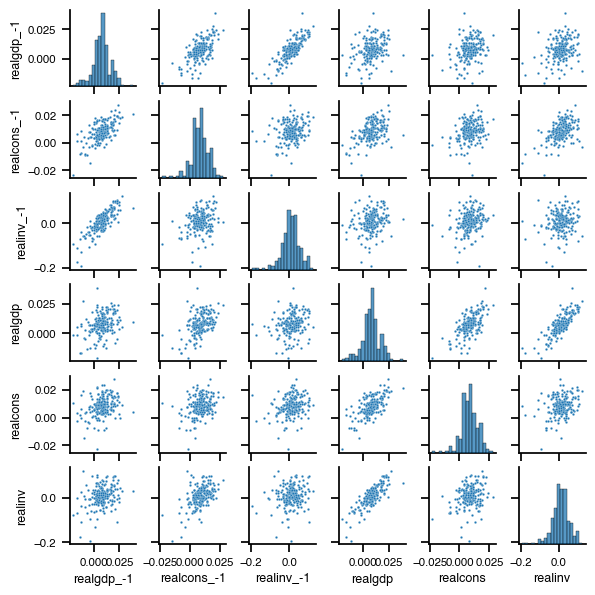

In [6]:
sns.set_context('notebook', font_scale=0.75)
sns.pairplot(X, height=1, plot_kws={'s': 3});

### Fit KDE model to data and simulate

To fit the KDE model reuse the `X` DataFrame, fitting a 6-dimensional KDE, noting that the base `gaussian_kde` class expects data with features as rows and instances as columns, hence the transpose:

In [7]:
kde = kt.gaussian_kde(X.T)
kde.factor

0.5887040186524746

In [8]:
kde.set_bandwidth('scott', bw_type='diagonal')
kde.factor

0.5887040186524746

Define an array to store the results and populate with the initial value of the training data

In [9]:
# Data index at which to start simulating
ix0 = 1

# Ensemble members M and time steps N to simulate
M, N = 1000, data.shape[0] - ix0

sims = np.zeros((M, N, 3))
sims[:,0] = data.iloc[ix0,:]
sims[:,1] = data.iloc[ix0-1,:]

Run time-stepping loop:

In [12]:
np.random.seed(0)

for i in tqdm(range(ix0, N)):
    x_cond = np.hstack([sims[:,i-1]])
    sims[:,[i]] = kde.conditional_resample(1, x_cond=x_cond, dims_cond=[0,1,2])

# Calculate mean of all simulations and 5th and 95th percentiles
sims_q05 = pd.DataFrame(np.quantile(sims, 0.05, axis=0), columns=data.columns).add_suffix('_5th')
sims_mean = pd.DataFrame(sims.mean(axis=0), columns=data.columns).add_suffix('mean')
sims_q95 = pd.DataFrame(np.quantile(sims, 0.95, axis=0), columns=data.columns).add_suffix('_95th')

  0%|          | 0/200 [00:00<?, ?it/s]

##### Find indices of ensemble members closest in RMSE sense to actual outcome

In [13]:
nearest = ((sims - data.iloc[ix0:].values)**2).sum(axis=1).argmin(axis=0)

##### Visualise the simulated results

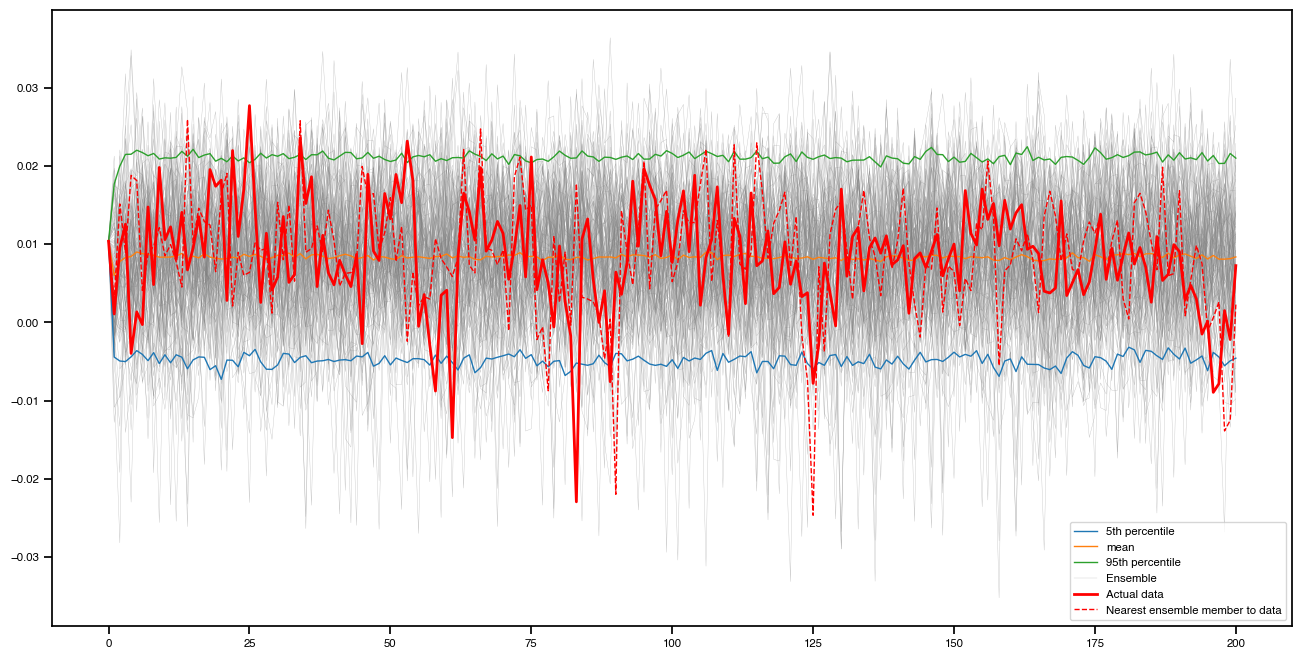

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
col_ix = 1

sims_q05[sims_q05.columns[col_ix]].plot(ax=ax, ls='-', lw=1, label='5th percentile')
sims_mean[sims_mean.columns[col_ix]].plot(ax=ax, ls='-', lw=1, label='mean')
sims_q95[sims_q95.columns[col_ix]].plot(ax=ax, ls='-', lw=1, label='95th percentile')

for i in range(min(M, 100)):
    ax.plot(sims[i,:,col_ix], color='0.5', lw=0.25, zorder=-3, alpha=0.5, label='Ensemble' if i==0 else None)

data[data.columns[col_ix]].iloc[ix0:].reset_index(drop=True).plot(ax=ax, lw=2, color='r', label='Actual data')
ax.plot(sims[nearest[col_ix],:,col_ix], color='r', ls='--', lw=1, label='Nearest ensemble member to data')
ax.legend();

##### Compare the cross- and autocorrelation statistics with a ravelled version of all realisations

In [15]:
sims_ravelled = pd.DataFrame(sims.reshape(-1,3), columns=data.columns)

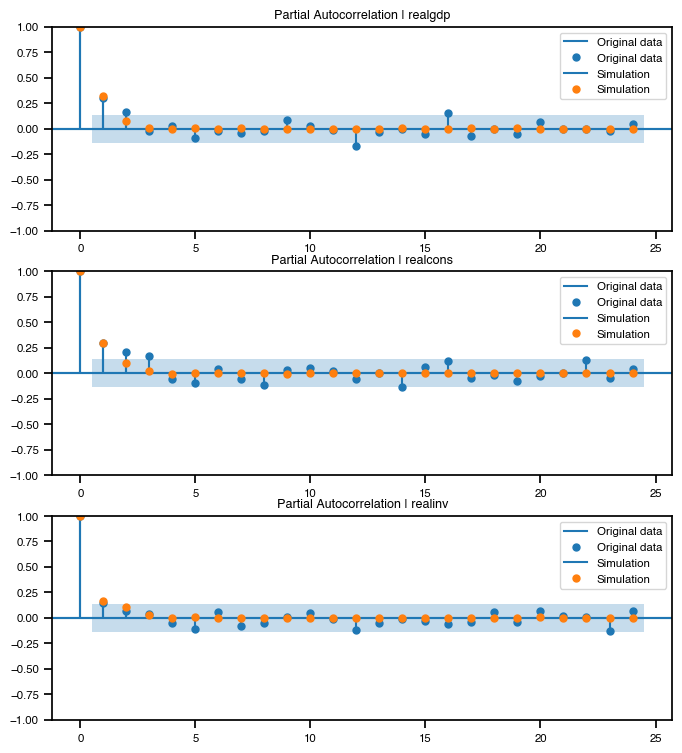

In [16]:
fig, axes = plt.subplots(3, 1, figsize=(8,9))
for i, v in enumerate(data.columns):
    ax = axes[i]
    plot_pacf(data[v], lags=24, ax=ax, label='Original data')
    plot_pacf(sims_ravelled[v], lags=24, ax=ax, label='Simulation')
    ax.legend(); ax.set_title(f'{ax.get_title()} | {v}');

In [17]:
pd.concat({'data': data.describe(), 'KDE': pd.DataFrame(sims_ravelled).describe()}, axis=1)

data                                    KDE                 \
          realgdp    realcons     realinv        realgdp       realcons   
count  202.000000  202.000000  202.000000  201000.000000  201000.000000   
mean     0.007758    0.008368    0.008143       0.007737       0.008370   
std      0.008798    0.006944    0.046848       0.010111       0.008055   
min     -0.020708   -0.022955   -0.193163      -0.036393      -0.036007   
25%      0.003345    0.004409   -0.015160       0.001714       0.003538   
50%      0.007652    0.008525    0.010199       0.007881       0.008529   
75%      0.012730    0.012831    0.034959       0.014122       0.013570   
max      0.038585    0.027733    0.122094       0.054714       0.041026   

                      
             realinv  
count  201000.000000  
mean        0.008102  
std         0.053875  
min        -0.271561  
25%        -0.022655  
50%         0.010158  
75%         0.042297  
max         0.204431

##### Compare correlation matrices

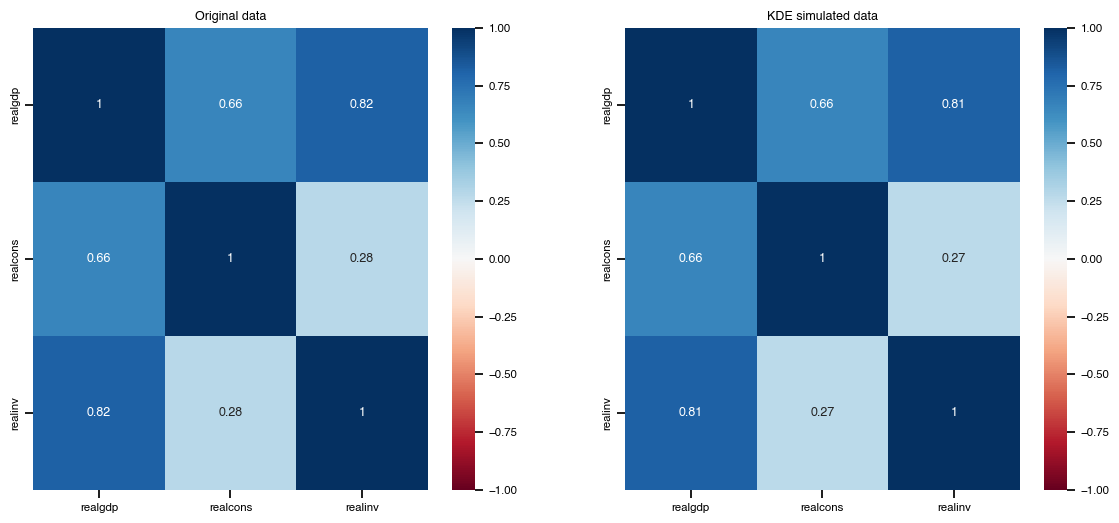

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
sns.heatmap(data.corr(), ax=ax1, vmin=-1, vmax=1, cmap='RdBu', annot=True); ax1.set_title('Original data')
sns.heatmap(sims_ravelled.corr(), ax=ax2, vmin=-1, vmax=1, cmap='RdBu', annot=True); ax2.set_title('KDE simulated data');

##### Calculate 2-sample Kolmogorov-Smirnov p-values between the original data and the KDE-simulated data:

In [19]:
for v in data.columns:
    print(f'K-S test p-value: {st.ks_2samp(data[v], sims_ravelled[v]).pvalue:.4f}')

K-S test p-value: 0.1490
K-S test p-value: 0.1646
K-S test p-value: 0.2797


##### Compare ECDFs

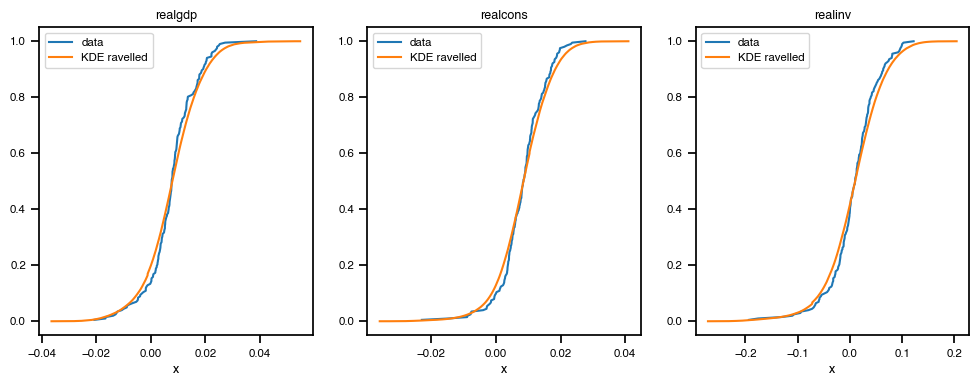

In [20]:
ecdf = kt.kdecdf()

fig, axes = plt.subplots(1, 3, figsize=(12,4))
for i in range(3):
    ax = axes[i]
    v = data.columns[i]
    pd.DataFrame({'x': data[v], 'ecdf': ecdf.calc_ecdf(data[v])}).sort_values('x').plot('x', 'ecdf', label='data', ax=ax)
    pd.DataFrame({'x': sims_ravelled[v], 'ecdf': ecdf.calc_ecdf(sims_ravelled[v])}).sort_values('x').plot('x', 'ecdf', label='KDE ravelled', ax=ax)
    ax.set_title(v);